In [21]:
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np 
%matplotlib inline

from keras.models import *
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, Cropping2D, concatenate, Activation, Reshape, Permute, Conv1D, Lambda
from keras.activations import softmax
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.utils import np_utils


### Load image data

In [22]:
im_full_stack = io.imread('20171214_MGAN0011_-ROIa2.tif') # 16 slice stack
im_labels = io.imread('20171214_MGAN0011_-ROIa2-CD3_labels.tif') # 16 slice stack
im_test = io.imread('20171214_MGAN0011_-ROIa2-CD3.tif')
im_size = im_labels.shape

# swap the dimentions for keras, so the channels are in the end
im_full_stack = np.moveaxis(im_full_stack, 0, 2)

### Visualize images

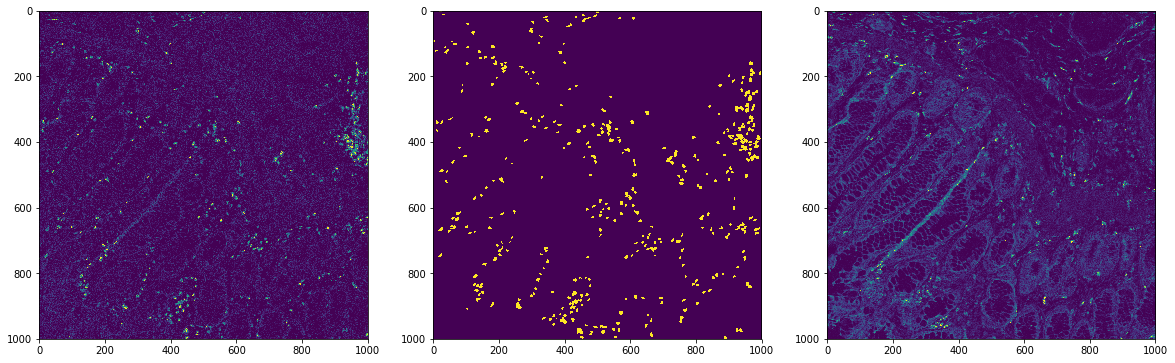

In [23]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
ax1.imshow(im_test)
ax2.imshow(im_labels)
ax3.imshow(im_full_stack[:,:,9])

### Create patches for training 

In [24]:
# randomly generate N patches of size patch_size
N = 3000
patch_size = 224

corner_i = np.random.randint(low = 0, high = im_size[0] - patch_size, size = N)
corner_j = np.random.randint(low = 0, high = im_size[0] - patch_size, size = N)

train_labels = []
train_data = []

Nreal = 0
for i, j in zip (corner_i, corner_j):
        if im_labels[i:i + patch_size, j:j + patch_size].sum() > 2000 * 255 :
            train_labels.append(im_labels[i:i + patch_size, j:j + patch_size])
            train_data.append(im_full_stack[i:i + patch_size, j:j + patch_size, :] / 65535)
            Nreal += 1

train_labels = np.asarray(train_labels) / 255
train_data   = np.asarray(train_data)


print (Nreal)

440


### Unet

In [25]:
inputs = Input((patch_size, patch_size, 16))
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
print(conv1.shape)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
print(conv2.shape)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
print(conv3.shape)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
print(conv4.shape)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
print(conv5.shape)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv11 = Conv2D(1, (1, 1), activation='sigmoid')(conv10)
#print(conv10.shape)
out = Reshape((patch_size, patch_size))(conv11)

model = Model(inputs=[inputs], outputs=[out])
''
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

(?, 224, 224, 32)
(?, 112, 112, 64)
(?, 56, 56, 128)
(?, 28, 28, 256)
(?, 14, 14, 512)


In [26]:
history = model.fit(train_data, train_labels, batch_size=16, epochs=10, verbose=1, shuffle=True,
              validation_split=0.1,
              callbacks=[])

Train on 396 samples, validate on 44 samples
Epoch 1/10
396/396 [==============================] - 14s - loss: 0.3503 - acc: 0.9389 - val_loss: 0.1897 - val_acc: 0.9489
Epoch 2/10
396/396 [==============================] - 14s - loss: 0.1232 - acc: 0.9534 - val_loss: 0.0754 - val_acc: 0.9678
Epoch 3/10
396/396 [==============================] - 14s - loss: 0.0552 - acc: 0.9772 - val_loss: 0.0486 - val_acc: 0.9792
Epoch 4/10
396/396 [==============================] - 14s - loss: 0.0445 - acc: 0.9808 - val_loss: 0.0449 - val_acc: 0.9803
Epoch 5/10
396/396 [==============================] - 14s - loss: 0.0409 - acc: 0.9823 - val_loss: 0.0407 - val_acc: 0.9822
Epoch 6/10
396/396 [==============================] - 14s - loss: 0.0366 - acc: 0.9842 - val_loss: 0.0353 - val_acc: 0.9849
Epoch 7/10
396/396 [==============================] - 14s - loss: 0.0322 - acc: 0.9863 - val_loss: 0.0333 - val_acc: 0.9859
Epoch 8/10
396/396 [==============================] - 13s - loss: 0.0286 - acc: 0.9879 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


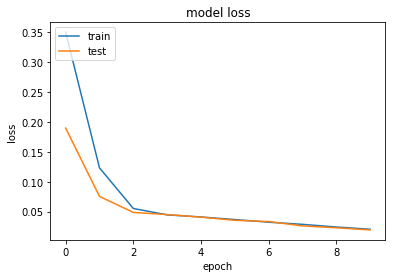

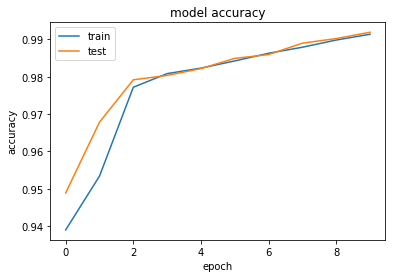

In [27]:
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


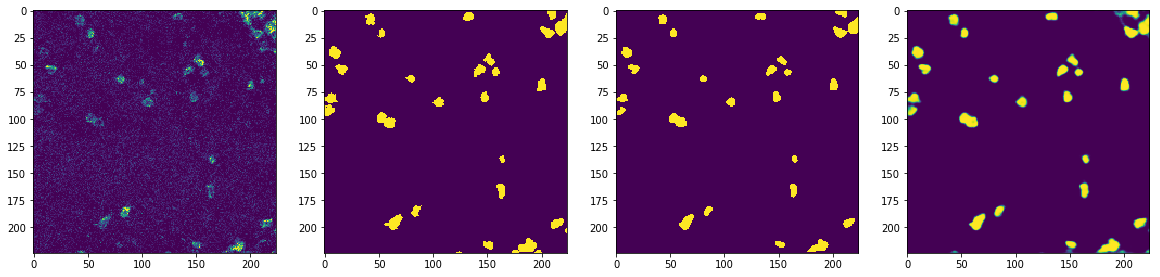

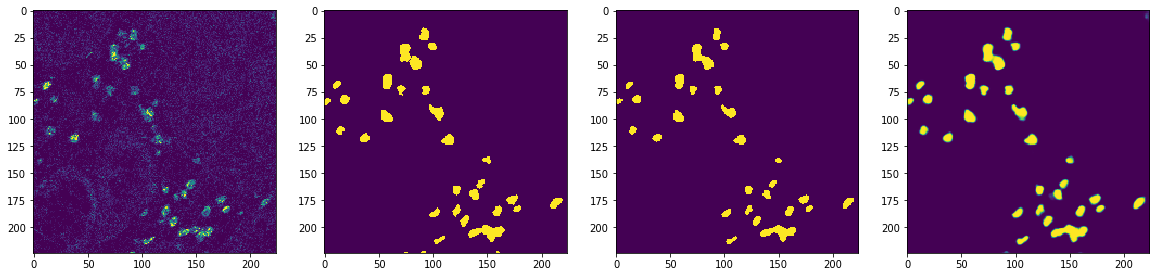

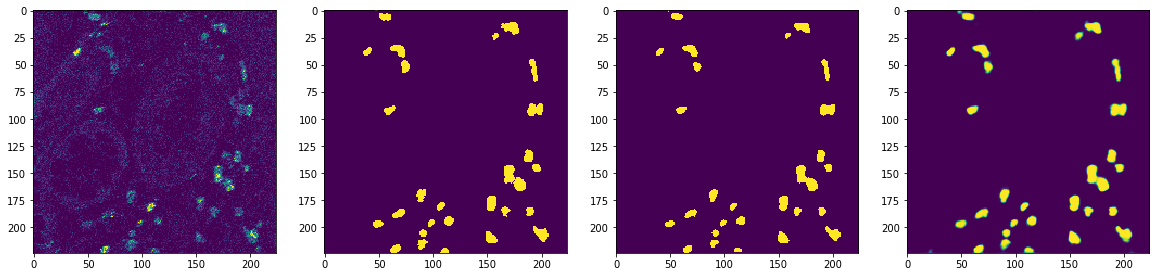

In [28]:
main_slice = 6
im_predict = model.predict(train_data[1:2,:,:, :])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[1,:,:,main_slice])
ax2.imshow(train_labels[1,:,:])
ax4.imshow(im_predict[0,:,:])
binarymask = im_predict[0,:,:]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)



im_predict = model.predict(train_data[5:6,:,:,:])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[5,:,:,main_slice])
ax2.imshow(train_labels[5,:,:])
ax4.imshow(im_predict[0,:,:])

binarymask = im_predict[0,:,:]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)

im_predict = model.predict(train_data[8:9,:,:,:])
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
ax1.imshow(train_data[8,:,:,main_slice])
ax2.imshow(train_labels[8,:,:])
ax4.imshow(im_predict[0,:,:])

binarymask = im_predict[0,:,:]
binarymask[binarymask >=0.8] = 1
binarymask[binarymask <0.8] = 0
ax3.imshow(binarymask)
